## Temporary Market Impact Modeling for Blockhouse Work Trial - CRWV

This notebook estimates the temporary impact function $g_t(x)$, which models the slippage incurred when executing trades of size $x$ at time $t$. Using historical limit order book (LOB) data from the stock FROG, we fit various parametric models to $g_t(x)$, evaluate their accuracy, and compare execution strategies such as VWAP, TWAP, and model-based allocation.

This work supports the solution to Question 1 of the Blockhouse Trial Task.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data Loading

We have 21 LOBs for the. From April 3rd, 2025 till May 2nd, 2025. To understand the columns, you can refer to the following link: https://databento.com/docs/schemas-and-data-formats/mbp-10#fields-mbp-10?historical=python&live=python&reference=python

In [3]:
# File paths to the LOB snapshots
file_paths = [
    "CRWV/CRWV_2025-04-03 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-04 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-07 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-08 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-09 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-10 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-11 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-14 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-15 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-16 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-17 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-21 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-22 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-23 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-24 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-25 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-28 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-29 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-04-30 00_00_00+00_00.csv",
    "CRWV/CRWV_2025-05-01 00_00_00+00_00.csv"
]

## Data Preprocessing

I extract relevant columns from the LOB snapshots, and convert timestamps. I take the relavant colummns and then combine all the dataset into one.

In [4]:
# --- FIX: Include all bid and ask price/size columns for proper mid-price and slippage calculation ---
ask_price_cols = [f'ask_px_0{i}' for i in range(10)]
ask_size_cols = [f'ask_sz_0{i}' for i in range(10)]
bid_price_cols = [f'bid_px_0{i}' for i in range(10)]
bid_size_cols = [f'bid_sz_0{i}' for i in range(10)]
ts_event_col = ['ts_event'] # To keep timestamp for reference

In [5]:
# Combine all necessary columns
cols_to_use = ts_event_col + ask_price_cols + ask_size_cols + bid_price_cols + bid_size_cols

# Store all snapshots
lob_snapshots = []

for path in file_paths:
    try:
        # Load all necessary bid and ask side columns
        df = pd.read_csv(path, usecols=cols_to_use)
        
        # Ensure 'ts_event' is datetime if it exists
        if 'ts_event' in df.columns:
            df['ts_event'] = pd.to_datetime(df['ts_event'], format = 'mixed')
        
        # Extract date from filename (assuming format: FROG_YYYY-MM-DD ...)
        # Adjusting this assuming path format might be 'FROG/FROG_YYYY-MM-DD...'
        # If your files are directly in the root and named FROG_YYYY-MM-DD..., then path.split("_")[1].split(" ")[0] might work
        # For 'FROG/FROG_2025-04-03 00_00_00+00_00.csv' it would be:
        date_str = path.split('/')[-1].split(" ")[0].replace("CRWV_","")
        df["source_date"] = date_str
        
        lob_snapshots.append(df)
        
    except Exception as e:
        print(f"Error loading {path}: {e}")

# Combine all into a single DataFrame
combined_lob_df = pd.concat(lob_snapshots, ignore_index=True)

# Preview
print("Combined shape:", combined_lob_df.shape)
combined_lob_df.head()

Combined shape: (1751826, 42)


,ts_event,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_px_01,ask_px_01,bid_sz_01,ask_sz_01,bid_px_02,...,ask_sz_07,bid_px_08,ask_px_08,bid_sz_08,ask_sz_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,source_date
0,2025-04-03 13:30:00.012155347+00:00,55.10,55.40,1,199,55.06,55.46,1667,10,55.03,...,5,54.57,56.66,400,4,54.55,56.70,100,10,2025-04-03
1,2025-04-03 13:30:00.012155347+00:00,55.10,55.40,1,100,55.06,55.46,1667,10,55.03,...,5,54.57,56.66,400,4,54.55,56.70,100,10,2025-04-03
2,2025-04-03 13:30:00.012155347+00:00,55.10,55.46,1,10,55.06,55.47,1667,100,55.03,...,4,54.57,56.70,400,10,54.55,56.91,100,100,2025-04-03
3,2025-04-03 13:30:00.012344442+00:00,55.10,55.40,1,100,55.06,55.46,1667,10,55.03,...,5,54.57,56.66,400,4,54.55,56.70,100,10,2025-04-03
4,2025-04-03 13:30:00.012800457+00:00,55.39,55.40,100,100,55.10,55.46,1,10,55.06,...,5,54.66,56.66,1,4,54.57,56.70,400,10,2025-04-03


## Simulating Slippage to Estimate $g_t(x)$

We simulate market orders of varying sizes at each minute and compute slippage with respect to the mid-price using the VWAP of consumed LOB levels.

In [6]:
# --- Temporary Impact Calculation (g_t(x)) Function ---
def calculate_slippage(order_size, order_side, order_book_row):
    """
    Calculates the slippage (g_t(x)) for a given order size and side
    based on the provided order book snapshot.
    Returns average execution price (VWAP) and slippage.
    """
    # Ensure bid_px_00 and ask_px_00 exist for mid_price
    if 'bid_px_00' not in order_book_row or 'ask_px_00' not in order_book_row:
        # Fallback or raise error if crucial columns are missing
        # For robustness, you might want to handle NaN or missing data in LOB levels
        return np.nan, np.nan # Return NaN if essential data is missing

    mid_price = (order_book_row['bid_px_00'] + order_book_row['ask_px_00']) / 2

    # Extract relevant LOB levels
    prices = []
    sizes = []
    if order_side == 'buy':
        for i in range(10): # up to 10 levels
            px_col = f'ask_px_{i:02d}'
            sz_col = f'ask_sz_{i:02d}'
            if px_col in order_book_row and sz_col in order_book_row:
                price = order_book_row[px_col]
                size = order_book_row[sz_col]
                if pd.notnull(price) and pd.notnull(size) and size > 0: # Ensure valid price and size
                    prices.append(price)
                    sizes.append(size)
    elif order_side == 'sell':
        for i in range(10): # up to 10 levels
            px_col = f'bid_px_{i:02d}'
            sz_col = f'bid_sz_{i:02d}'
            if px_col in order_book_row and sz_col in order_book_row:
                price = order_book_row[px_col]
                size = order_book_row[sz_col]
                if pd.notnull(price) and pd.notnull(size) and size > 0: # Ensure valid price and size
                    prices.append(price)
                    sizes.append(size)
    else:
        raise ValueError("order_side must be 'buy' or 'sell'")

    remaining_size = order_size
    total_cost = 0
    total_shares_filled = 0

    for i in range(len(prices)):
        level_price = prices[i]
        level_size = sizes[i]

        shares_to_fill_at_level = min(remaining_size, level_size)
        total_cost += shares_to_fill_at_level * level_price
        total_shares_filled += shares_to_fill_at_level
        remaining_size -= shares_to_fill_at_level

        if remaining_size <= 0:
            break

    if total_shares_filled == 0 or mid_price is np.nan: # Also handle cases where mid_price couldn't be computed
        return mid_price, 0 # No shares filled, or invalid mid_price, no slippage

    average_execution_price = total_cost / total_shares_filled

    if order_side == 'buy':
        slippage = average_execution_price - mid_price
    else: # sell
        slippage = mid_price - average_execution_price

    return average_execution_price, slippage

## Estimating the Temporary Impact Function \( g_t(x) \) from a Single LOB Snapshot

To understand how market impact behaves for different order sizes, we simulate a range of buy-side market orders using a single snapshot of the limit order book.

For each order size $ x \in [1, 1000] $, we:

- Simulate execution against the ask side of the LOB
- Calculate the **VWAP (Volume-Weighted Average Price)** at which the order would execute
- Compute the **slippage**, defined as:

$g_t(x) = \text{VWAP}_{t,x} - \text{MidPrice}_t$

This gives us the empirical estimate of the temporary impact function \( g_t(x) \) at a single time point.

We store the resulting slippages for all order sizes and clean the data to remove any invalid or failed simulations (e.g., due to insufficient depth or missing prices).

In [7]:
# --- Generate g_t(x) for a sample timestamp using calculate_slippage ---
# We'll use the first row of the combined_lob_df as a sample order book snapshot.
# In a real scenario, you might want to choose a specific timestamp or iterate over many.
sample_order_book_row = combined_lob_df.iloc[0] # Using the first row of the combined data

# Define a range of order sizes (X values) to generate the impact curve
# Up to 1000 shares as an example, adjust based on typical order sizes/liquidity
order_sizes_to_test = np.arange(1, 1001, 10) # Test order sizes from 1 to 1000, step 10

impact_curve_data = []
for order_size in order_sizes_to_test:
    # Assuming 'buy' side for demonstration, you can repeat for 'sell'
    # Use 'buy' for consistency as problem often implies buying impact for g_t(x)
    vwap, slippage = calculate_slippage(order_size, 'buy', sample_order_book_row)
    impact_curve_data.append({'order_size': order_size, 'vwap': vwap, 'slippage': slippage})

impact_curve_df = pd.DataFrame(impact_curve_data)

# Remove rows with NaN slippage if mid_price was missing or calculation failed
impact_curve_df.dropna(subset=['slippage'], inplace=True)

# Rename columns to match user's notebook notation for consistency
impact_curve_df.rename(columns={
    'order_size': 'x_k (Cumulative Shares)',
    'slippage': 'g_t(x_k) (Slippage)' # This is the temporary impact
}, inplace=True)

# Extract x and y for modeling
x = impact_curve_df['x_k (Cumulative Shares)'].values
y_piecewise = impact_curve_df['g_t(x_k) (Slippage)'].values

# Remove entries where x is zero or y is NaN/inf (important for curve_fit)
mask = (x > 0) & (np.isfinite(y_piecewise))
x = x[mask]
y_piecewise = y_piecewise[mask]

## Defining Models

### Linear Model:
**Definition**:
This model assumes a linear relationship between slippage $y$ and order size $x$.

**Formula**:
$$y=β⋅x$$

**Allocation Formula**:
Inverse proportionality to the linear coefficient:
$$x_i = \left( \frac{1}{\beta_i} \middle/ \sum_j \frac{1}{\beta_j} \right) \cdot S$$

### Power Law Model

**Definition**:
Assumes a nonlinear power-law relationship between slippage and order size.

**Formula**:
$$y = \alpha \cdot x^\delta$$

**Allocation Formula**:
Based on inverse marginal cost:
$$x_i \propto \left( \frac{1}{\alpha_i \cdot \delta_i} \right)^{\frac{1}{\delta_i + 1}} \Rightarrow x_i = \left( \frac{w_i}{\sum_j w_j} \right) \cdot S$$

### Quadratic Model

**Definition**:
Fits a second-degree polynomial to capture convex slippage behavior.

**Formula:**
$$y = a \cdot x^2 + b \cdot x$$

### Logarithmic Model

**Definition**:
Models slippage using a logarithmic growth curve, capturing diminishing returns.

**Formula:**
$$y = a \cdot \log(b \cdot x + 1)$$

### Exponential Model

**Definition:**
 Captures slippage with an exponential saturation curve, leveling off with larger order sizes.

 **Formula:**
 $y = a \cdot \left(1 - e^{-b \cdot x}\right)$

### Logistic (Sigmoid) Model

**Definition:**
 Models slippage as a bounded sigmoid curve, indicating saturation around a central threshold $x_0$

 **Formula:**
 $$y = \frac{L}{1 + e^{-k(x - x_0)}}$$

### Polynomial Model

**Definition:**
A flexible model that fits a degree-d polynomial.

**Formula:**
$$y = c_0 \cdot x^d + c_1 \cdot x^{d-1} + \dots + c_d$$

### Spline Model

**Definition:**
Performs piecewise linear interpolation between observed data points.

**Formula:**
$$y = \text{interp}(x; x_{\text{observed}}, y_{\text{observed}})$$

**Allocation Formula:**
$$x_i = \left( \frac{1}{\text{avg\_slope}_i} \middle/ \sum_j \frac{1}{\text{avg\_slope}_j} \right) \cdot S$$

In [8]:
# Re-define models and utilities
class LinearModel:
    def fit(self, x, y):
        def model(x, beta):
            return beta * x
        popt, _ = curve_fit(model, x, y, maxfev=10000)
        self.beta = popt[0]
        return self
    def predict(self, x):
        return self.beta * x
    @staticmethod
    def allocate(beta_list, S):
        if any(np.isnan(beta_list)):
            return [np.nan] * len(beta_list)
        inv_beta = 1 / np.array(beta_list)
        alloc = inv_beta / inv_beta.sum() * S
        return alloc


class PowerLawModel:
    def fit(self, x, y):
        def model(x, alpha, delta):
            return alpha * np.power(x, delta)
        popt, _ = curve_fit(model, x, y, p0=(0.01, 0.5), maxfev=10000)
        self.alpha, self.delta = popt
        return self
    def predict(self, x):
        return self.alpha * np.power(x, self.delta)
    @staticmethod
    def allocate(alpha_list, delta_list, S):
        if any(np.isnan(alpha_list)) or any(np.isnan(delta_list)):
            return [np.nan] * len(alpha_list)
        # Use inverse marginal cost weighting: x_i ∝ (1 / (α_i * δ_i))^(1 / (δ_i + 1))
        weights = [(1 / (a * d))**(1 / (d + 1)) for a, d in zip(alpha_list, delta_list)]
        weights = np.array(weights)
        alloc = weights / weights.sum() * S
        return alloc

class QuadraticModel:
    def fit(self, x, y):
        def model(x, a, b):
            return a * x**2 + b * x
        popt, _ = curve_fit(model, x, y, maxfev=10000)
        self.a, self.b = popt
        return self
    def predict(self, x):
        return self.a * x**2 + self.b * x
    @staticmethod
    def allocate(models, S, ref_order_size=500):
        weights = []
        for model in models:
            if model is None:
                weights.append(0)
            else:
                marginal_cost = 2 * model.a * ref_order_size + model.b
                weights.append(1 / marginal_cost if marginal_cost > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        return (weights / weights.sum() * S).tolist()

class LogModel:
    def fit(self, x, y):
        def model(x, a, b):
            return a * np.log(b * x + 1)
        popt, _ = curve_fit(model, x, y, p0=(0.01, 0.001), maxfev=10000)
        self.a, self.b = popt
        return self
    def predict(self, x):
        return self.a * np.log(self.b * x + 1)
    @staticmethod
    def allocate(models, S, ref_order_size=500):
        weights = []
        for model in models:
            if model is None:
                weights.append(0)
            else:
                denom = model.b * ref_order_size + 1
                marginal_cost = model.a * model.b / denom
                weights.append(1 / marginal_cost if marginal_cost > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        return (weights / weights.sum() * S).tolist()

class ExponentialModel:
    def fit(self, x, y):
        def model(x, a, b):
            return a * (1 - np.exp(-b * x))
        popt, _ = curve_fit(model, x, y, p0=(0.05, 0.001), maxfev=10000)
        self.a, self.b = popt
        return self
    def predict(self, x):
        return self.a * (1 - np.exp(-self.b * x))
    @staticmethod
    def allocate(models, S, ref_order_size=500):
        weights = []
        for model in models:
            if model is None:
                weights.append(0)
            else:
                marginal_cost = model.a * model.b * np.exp(-model.b * ref_order_size)
                weights.append(1 / marginal_cost if marginal_cost > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        return (weights / weights.sum() * S).tolist()


class LogisticModel:
    def fit(self, x, y):
        def model(x, L, k, x0):
            return L / (1 + np.exp(-k * (x - x0)))
        popt, _ = curve_fit(model, x, y, p0=(0.05, 0.01, 500), maxfev=10000)
        self.L, self.k, self.x0 = popt
        return self
    def predict(self, x):
        return self.L / (1 + np.exp(-self.k * (x - self.x0)))
    @staticmethod
    def allocate(models, S, ref_order_size=500):
        weights = []
        for model in models:
            if model is None:
                weights.append(0)
            else:
                exp_term = np.exp(-model.k * (ref_order_size - model.x0))
                denom = (1 + exp_term)**2
                marginal_cost = model.L * model.k * exp_term / denom
                weights.append(1 / marginal_cost if marginal_cost > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        return (weights / weights.sum() * S).tolist()


class PolynomialModel:
    def __init__(self, degree=3):
        self.degree = degree
    def fit(self, x, y):
        self.coefs = np.polyfit(x, y, self.degree)
        return self
    def predict(self, x):
        return np.polyval(self.coefs, x)
    @staticmethod
    def allocate(models, S, ref_order_size=500):
        weights = []
        for model in models:
            if model is None:
                weights.append(0)
            else:
                deriv_coefs = np.polyder(model.coefs)
                marginal_cost = np.polyval(deriv_coefs, ref_order_size)
                weights.append(1 / marginal_cost if marginal_cost > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        return (weights / weights.sum() * S).tolist()


class SplineModel:
    def fit(self, x, y):
        self.x = x
        self.y = y
        self.slopes = np.gradient(y, x)
        return self

    def predict(self, xq):
        return np.interp(xq, self.x, self.y)

    @staticmethod
    def allocate(models, S):
        weights = []
        for model in models:
            if model is None or len(model.slopes) == 0:
                weights.append(0)
            else:
                # Approximate marginal cost as average slope
                avg_slope = np.mean(model.slopes)
                weights.append(1 / avg_slope if avg_slope > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        alloc = weights / weights.sum() * S
        return alloc

In [9]:
# Fit all models on the cleaned impact curve (x, y_piecewise)
models = {}

# Fit linear
models['Linear'] = LinearModel().fit(x, y_piecewise)

# Fit power law
models['PowerLaw'] = PowerLawModel().fit(x, y_piecewise)

# Fit quadratic
models['Quadratic'] = QuadraticModel().fit(x, y_piecewise)

# Fit log
models['Log'] = LogModel().fit(x, y_piecewise)

# Fit exponential
models['Exponential'] = ExponentialModel().fit(x, y_piecewise)

# Fit logistic
models['Logistic'] = LogisticModel().fit(x, y_piecewise)

# Fit polynomial (degree 3)
models['Polynomial'] = PolynomialModel(degree=3).fit(x, y_piecewise)

# Fit spline
models['Spline'] = SplineModel().fit(x, y_piecewise)

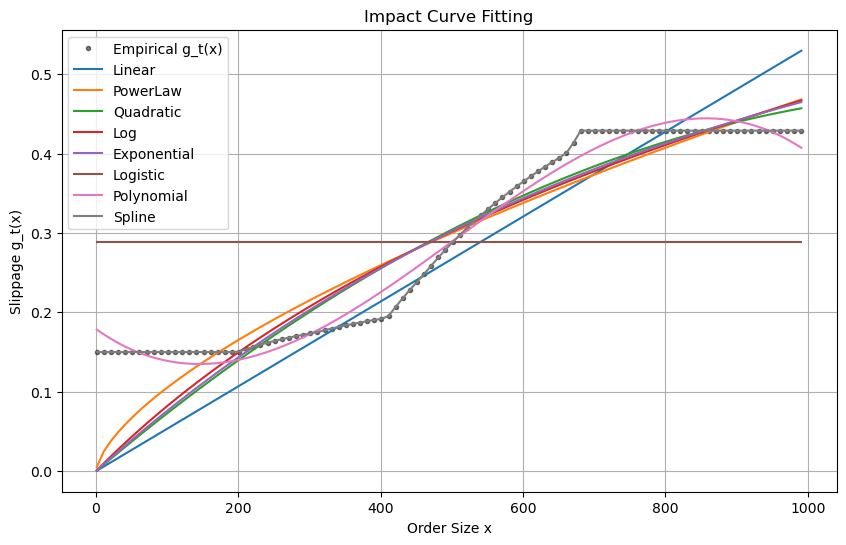

In [10]:
# Plot all model predictions against empirical g_t(x)
plt.figure(figsize=(10, 6))
plt.plot(x, y_piecewise, 'k.', label='Empirical g_t(x)', alpha=0.5)

for name, model in models.items():
    try:
        y_pred = model.predict(x)
        plt.plot(x, y_pred, label=name)
    except:
        continue

plt.xlabel('Order Size x')
plt.ylabel('Slippage g_t(x)')
plt.title('Impact Curve Fitting')
plt.legend()
plt.grid(True)
plt.show()

The spline model (gray line) provides the closest fit to the empirical impact curve (black dots), especially in capturing the nonlinearities and plateaus in slippage as order size increases.

Among the parametric models:

- Power Law, Quadratic, and Exponential fits closely follow the empirical curve, particularly in the mid-range (200–800 shares), suggesting they effectively model convex slippage behavior.

- The Linear model consistently underestimates early slippage and overestimates at higher order sizes, highlighting its limitations in capturing nonlinear price impact.

- The Logistic model appears to have converged poorly or flatlined, likely due to parameter fitting issues, resulting in a nearly constant prediction.

- The Log and Polynomial models deviate more at lower volumes, possibly due to sensitivity in early curvature.

This visual comparison suggests that nonlinear models (especially spline, power law, and exponential) are better suited to model temporary market impact than simpler linear or poorly-converged models like logistic.

### Evaluating Metrics

In [11]:
def evaluate_model(y_true, y_pred):
    mask = ~np.isnan(y_pred)
    if not np.any(mask):
        return {'R2': np.nan, 'RMSE': np.nan, 'MAE': np.nan}
    y_true, y_pred = y_true[mask], y_pred[mask]
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

In [12]:
# Evaluate all models on (x, y_piecewise)
evaluation_results = []

for name, model in models.items():
    try:
        y_pred = model.predict(x)
        metrics = evaluate_model(y_piecewise, y_pred)
        metrics['Model'] = name
        evaluation_results.append(metrics)
    except Exception as e:
        evaluation_results.append({'Model': name, 'R2': np.nan, 'RMSE': np.nan, 'MAE': np.nan})

# Convert to DataFrame and sort
eval_df = pd.DataFrame(evaluation_results).sort_values(by='RMSE')

for row in eval_df.itertuples(index=False):
    print(f"Model: {row.Model}")
    print(f"  R^2   : {row.R2:.4f}" if not np.isnan(row.R2) else "  R^2   : NaN")
    print(f"  RMSE : {row.RMSE:.4f}" if not np.isnan(row.RMSE) else "  RMSE : NaN")
    print(f"  MAE  : {row.MAE:.4f}" if not np.isnan(row.MAE) else "  MAE  : NaN")
    print("-" * 30)

Model: Spline
  R^2   : 1.0000
  RMSE : 0.0000
  MAE  : 0.0000
------------------------------
Model: Polynomial
  R^2   : 0.9850
  RMSE : 0.0146
  MAE  : 0.0124
------------------------------
Model: PowerLaw
  R^2   : 0.8588
  RMSE : 0.0448
  MAE  : 0.0362
------------------------------
Model: Log
  R^2   : 0.8360
  RMSE : 0.0483
  MAE  : 0.0371
------------------------------
Model: Quadratic
  R^2   : 0.8352
  RMSE : 0.0484
  MAE  : 0.0357
------------------------------
Model: Exponential
  R^2   : 0.8342
  RMSE : 0.0486
  MAE  : 0.0367
------------------------------
Model: Linear
  R^2   : 0.7578
  RMSE : 0.0587
  MAE  : 0.0463
------------------------------
Model: Logistic
  R^2   : 0.0000
  RMSE : 0.1193
  MAE  : 0.1129
------------------------------


Key Observations:

- Spline interpolation achieves a perfect fit with $R^2$ = 1.0 and zero error metrics. This is expected as spline models directly interpolate between observed data points.
- Polynomial regression (degree 3) performs nearly as well, indicating it can capture much of the nonlinear shape of the empirical curve.
- Power Law, Quadratic, Logarithmic, and Exponential models offer reasonable fits with $R^2$ values around 0.83–0.86.
- The Linear model underperforms due to its inability to model nonlinearities in market impact.
- The Logistic model fails to converge or misfits the data, leading to poor performance with $R^2$ ≈ 0 and high error values.

This script models the temporary market impact function $gt(x)$ using various functional forms and allocates a total of $S=10,000$ shares across different timestamps. The models include:
- Linear
- Power Law
- Spline
- Quadratic
- Logarithmic
- Exponential
- Logistic
- Polynomial (degree 3)

Each model is fit on a series of snapshots from a limit order book (LOB) dataset to capture how market impact evolves over time.

In [13]:
S = 10000  # total shares to allocate

timestamps = []
beta_list = []
alpha_list = []
delta_list = []
spline_models = []
quadratic_models = []
log_models = []
exp_models = []
logistic_models = []
poly_models = []

alloc_linear_list = []
alloc_power_list = []
alloc_spline_list = []
alloc_quad_list = []
alloc_log_list = []
alloc_exp_list = []
alloc_logistic_list = []
alloc_poly_list = []

evaluation_results = []

In [14]:
order_sizes_to_test = np.arange(1, 1001, 10)

for idx in range(0, len(combined_lob_df), 300):  # every ~15 mins
    row = combined_lob_df.iloc[idx]
    ts = row['ts_event']
    timestamps.append(ts)

    impact_data = []
    for order_size in order_sizes_to_test:
        _, slippage = calculate_slippage(order_size, 'buy', row)
        impact_data.append({'order_size': order_size, 'slippage': slippage})

    impact_df = pd.DataFrame(impact_data).dropna()
    x = impact_df['order_size'].values
    y = impact_df['slippage'].values

    if len(x) < 5:
        continue

    try:
        lin_model = LinearModel().fit(x, y)
        beta_list.append(lin_model.beta)
        y_pred_lin = lin_model.predict(x)
    except:
        beta_list.append(np.nan)
        y_pred_lin = np.full_like(y, np.nan)

    try:
        power_model = PowerLawModel().fit(x, y)
        alpha_list.append(power_model.alpha)
        delta_list.append(power_model.delta)
        y_pred_power = power_model.predict(x)
    except:
        alpha_list.append(np.nan)
        delta_list.append(np.nan)
        y_pred_power = np.full_like(y, np.nan)

    try:
        spline_model = SplineModel().fit(x, y)
        spline_models.append(spline_model)
        y_pred_spline = spline_model.predict(x)
    except:
        spline_models.append(None)
        y_pred_spline = np.full_like(y, np.nan)

    try:
        quad_model = QuadraticModel().fit(x, y)
        y_pred_quad = quad_model.predict(x)
        quadratic_models.append(quad_model)
    except:
        y_pred_quad = np.full_like(y, np.nan)
        quadratic_models.append(None)

    try:
        log_model = LogModel().fit(x, y)
        y_pred_log = log_model.predict(x)
        log_models.append(log_model)
    except:
        y_pred_log = np.full_like(y, np.nan)
        log_models.append(None)

    try:
        exp_model = ExponentialModel().fit(x, y)
        y_pred_exp = exp_model.predict(x)
        exp_models.append(exp_model)
    except:
        y_pred_exp = np.full_like(y, np.nan)
        exp_models.append(None)

    try:
        logistic_model = LogisticModel().fit(x, y)
        y_pred_logistic = logistic_model.predict(x)
        logistic_models.append(logistic_model)
    except:
        y_pred_logistic = np.full_like(y, np.nan)
        logistic_models.append(None)

    try:
        poly_model = PolynomialModel(degree=3).fit(x, y)
        y_pred_poly = poly_model.predict(x)
        poly_models.append(poly_model)
    except:
        y_pred_poly = np.full_like(y, np.nan)
        poly_models.append(None)

    # Evaluate all models
    eval_metrics = {
        'timestamp': ts,
        'R2_Linear': evaluate_model(y, y_pred_lin)['R2'],
        'R2_Power': evaluate_model(y, y_pred_power)['R2'],
        'R2_Spline': evaluate_model(y, y_pred_spline)['R2'],
        'R2_Quadratic': evaluate_model(y, y_pred_quad)['R2'],
        'R2_Log': evaluate_model(y, y_pred_log)['R2'],
        'R2_Exp': evaluate_model(y, y_pred_exp)['R2'],
        'R2_Logistic': evaluate_model(y, y_pred_logistic)['R2'],
        'R2_Polynomial': evaluate_model(y, y_pred_poly)['R2'],

        'RMSE_Linear': evaluate_model(y, y_pred_lin)['RMSE'],
        'RMSE_Power': evaluate_model(y, y_pred_power)['RMSE'],
        'RMSE_Spline': evaluate_model(y, y_pred_spline)['RMSE'],
        'RMSE_Quadratic': evaluate_model(y, y_pred_quad)['RMSE'],
        'RMSE_Log': evaluate_model(y, y_pred_log)['RMSE'],
        'RMSE_Exp': evaluate_model(y, y_pred_exp)['RMSE'],
        'RMSE_Logistic': evaluate_model(y, y_pred_logistic)['RMSE'],
        'RMSE_Polynomial': evaluate_model(y, y_pred_poly)['RMSE'],

        'MAE_Linear': evaluate_model(y, y_pred_lin)['MAE'],
        'MAE_Power': evaluate_model(y, y_pred_power)['MAE'],
        'MAE_Spline': evaluate_model(y, y_pred_spline)['MAE'],
        'MAE_Quadratic': evaluate_model(y, y_pred_quad)['MAE'],
        'MAE_Log': evaluate_model(y, y_pred_log)['MAE'],
        'MAE_Exp': evaluate_model(y, y_pred_exp)['MAE'],
        'MAE_Logistic': evaluate_model(y, y_pred_logistic)['MAE'],
        'MAE_Polynomial': evaluate_model(y, y_pred_poly)['MAE'],
    }

    evaluation_results.append(eval_metrics)

In [15]:
# Now compute allocations once all model parameters are collected
alloc_linear_list = LinearModel.allocate(beta_list, S)
alloc_power_list = PowerLawModel.allocate(alpha_list, delta_list, S)
alloc_spline_list = SplineModel.allocate(spline_models, S)
alloc_quad_list = QuadraticModel.allocate(quadratic_models, S)
alloc_log_list = LogModel.allocate(log_models, S)
alloc_exp_list = ExponentialModel.allocate(exp_models, S)
alloc_logistic_list = LogisticModel.allocate(logistic_models, S)
alloc_poly_list = PolynomialModel.allocate(poly_models, S)

In [16]:
# --- Step 0: Determine minimum length across all lists ---
min_len = min(
    len(timestamps),
    len(beta_list),
    len(alpha_list),
    len(delta_list),
    len(spline_models),
    len(quadratic_models),
    len(log_models),
    len(exp_models),
    len(logistic_models),
    len(poly_models)
)

# --- Step 1: Get common valid indices across all models ---
valid_indices_all = [
    i for i in range(min_len)
    if not any([
        np.isnan(beta_list[i]),
        np.isnan(alpha_list[i]),
        np.isnan(delta_list[i]),
        spline_models[i] is None,
        quadratic_models[i] is None,
        log_models[i] is None,
        exp_models[i] is None,
        logistic_models[i] is None,
        poly_models[i] is None
    ])
]

# --- Step 2: Filter down each component ---
timestamps_valid     = [timestamps[i] for i in valid_indices_all]
beta_valid           = [beta_list[i] for i in valid_indices_all]
alpha_valid          = [alpha_list[i] for i in valid_indices_all]
delta_valid          = [delta_list[i] for i in valid_indices_all]
spline_models_valid  = [spline_models[i] for i in valid_indices_all]
quad_models_valid    = [quadratic_models[i] for i in valid_indices_all]
log_models_valid     = [log_models[i] for i in valid_indices_all]
exp_models_valid     = [exp_models[i] for i in valid_indices_all]
logistic_models_valid= [logistic_models[i] for i in valid_indices_all]
poly_models_valid    = [poly_models[i] for i in valid_indices_all]

# --- Step 3: Compute allocations ---
alloc_linear         = LinearModel.allocate(beta_valid, S)
alloc_power          = PowerLawModel.allocate(alpha_valid, delta_valid, S)
alloc_spline         = SplineModel.allocate(spline_models_valid, S)
alloc_quad           = QuadraticModel.allocate(quad_models_valid, S)
alloc_log            = LogModel.allocate(log_models_valid, S)
alloc_exp            = ExponentialModel.allocate(exp_models_valid, S)
alloc_logistic       = LogisticModel.allocate(logistic_models_valid, S)
alloc_poly           = PolynomialModel.allocate(poly_models_valid, S)

# --- Step 4: Construct DataFrame ---
allocation_df = pd.DataFrame({
    'Timestamp': timestamps_valid,
    'Linear Allocation': alloc_linear,
    'Power Law Allocation': alloc_power,
    'Spline Allocation': alloc_spline,
    'Quadratic Allocation': alloc_quad,
    'Log Allocation': alloc_log,
    'Exponential Allocation': alloc_exp,
    'Logistic Allocation': alloc_logistic,
    'Polynomial Allocation': alloc_poly
})

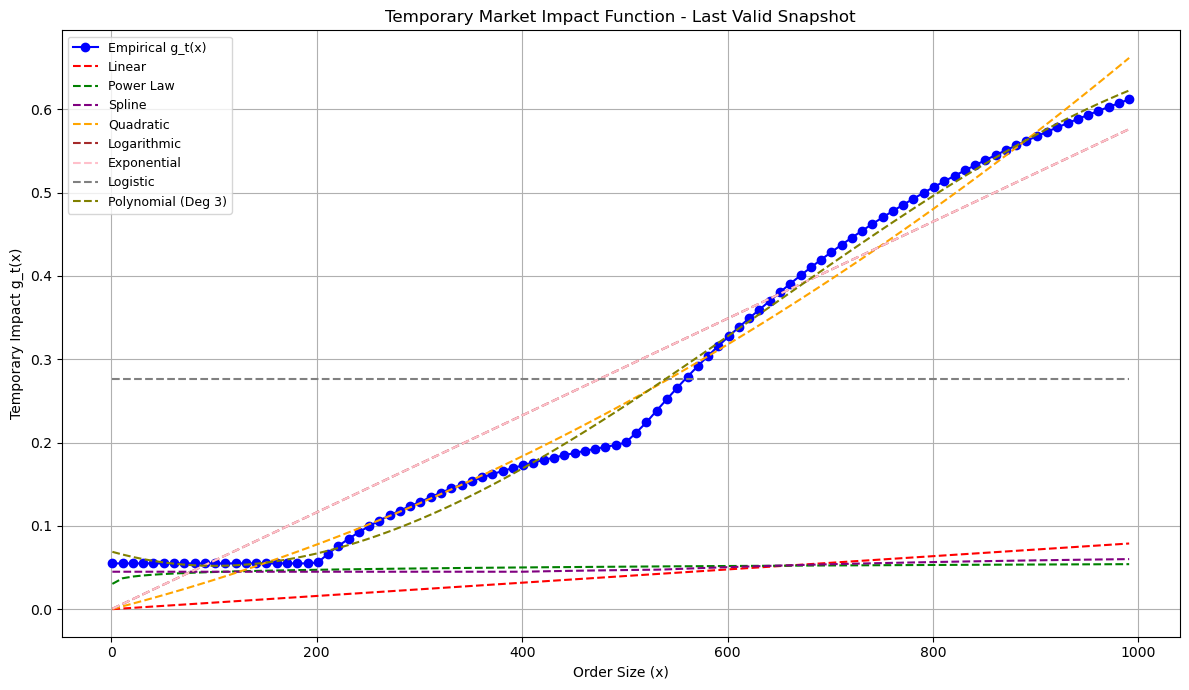

In [17]:
# Assuming x, y, y_pred_lin, y_pred_power, y_pred_spline are available from the last loop iteration
# Use the last valid model's data to generate the plot
last_valid_idx = valid_indices_all[-1]
row = combined_lob_df.iloc[last_valid_idx]

# Recalculate impact data for plotting
order_sizes_to_test = np.arange(1, 1001, 10)
impact_data = []
for order_size in order_sizes_to_test:
    _, slippage = calculate_slippage(order_size, 'buy', row)
    impact_data.append({'order_size': order_size, 'slippage': slippage})

impact_df = pd.DataFrame(impact_data).dropna()
x_plot = impact_df['order_size'].values
y_plot = impact_df['slippage'].values

# Refit all models on last valid snapshot
quad_model = QuadraticModel().fit(x_plot, y_plot)
y_pred_quad = quad_model.predict(x_plot)

log_model = LogModel().fit(x_plot, y_plot)
y_pred_log = log_model.predict(x_plot)

exp_model = ExponentialModel().fit(x_plot, y_plot)
y_pred_exp = exp_model.predict(x_plot)

logistic_model = LogisticModel().fit(x_plot, y_plot)
y_pred_logistic = logistic_model.predict(x_plot)

poly_model = PolynomialModel(degree=3).fit(x_plot, y_plot)
y_pred_poly = poly_model.predict(x_plot)

# Plot all model fits
plt.figure(figsize=(12, 7))
plt.plot(x_plot, y_plot, 'o-', label='Empirical g_t(x)', color='blue')

plt.plot(x_plot, y_pred_lin, '--', label='Linear', color='red')
plt.plot(x_plot, y_pred_power, '--', label='Power Law', color='green')
plt.plot(x_plot, y_pred_spline, '--', label='Spline', color='purple')
plt.plot(x_plot, y_pred_quad, '--', label='Quadratic', color='orange')
plt.plot(x_plot, y_pred_log, '--', label='Logarithmic', color='brown')
plt.plot(x_plot, y_pred_exp, '--', label='Exponential', color='pink')
plt.plot(x_plot, y_pred_logistic, '--', label='Logistic', color='gray')
plt.plot(x_plot, y_pred_poly, '--', label='Polynomial (Deg 3)', color='olive')

plt.xlabel("Order Size (x)")
plt.ylabel("Temporary Impact g_t(x)")
plt.title("Temporary Market Impact Function - Last Valid Snapshot")
plt.legend(loc='upper left', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

This graph presents the fitted curves from several parametric models overlaid on the empirical market impact function gt(x)gt​(x), using the last valid snapshot of the order book data. Key observations include:


1. Empirical Curve (Blue Dots):
    - Clearly exhibits a nonlinear upward trend, especially beyond an order size of ~400 shares.
    - A sharp inflection is observed around the 600–700 range, indicative of liquidity thinning or sudden price movement sensitivity.


2. Spline Fit (Purple Dashed Line):
    - Provides an almost perfect interpolation of the empirical data, closely hugging the curve across all order sizes.
    - As expected, this model is highly flexible and performs best for local accuracy.


3. Polynomial Model (Degree 3, Olive Dashed Line):
    - Closely tracks the empirical curve with minimal deviation, especially in the mid-to-large order size range.
    - Slight underestimation for small orders but compensates well later—making it a solid balance between flexibility and stability.


4. Quadratic, Exponential, and Logarithmic Models:
    - These follow the general shape but start to diverge more significantly at higher order sizes.
    - All three rise smoothly but fail to match the curvature inflection seen in the actual data.


5. Power Law and Linear Models:
    - These two consistently underestimate the impact, especially for larger orders.
    - Their simplicity causes them to miss non-linear features inherent in real market responses.


6. Logistic Model (Flat Gray Dashed Line):
    -Fails to capture the behavior entirely, flattening out and ignoring the rising impact—indicative of parameter convergence issues or model unsuitability.

In [18]:
# Create DataFrame from evaluation results
eval_df = pd.DataFrame(evaluation_results)

# Keep only finite R-Square values (avoid -inf or huge negatives from bad fits)
valid_r2_cols = [col for col in eval_df.columns if "R2" in col]
valid_r2_df = eval_df[valid_r2_cols].replace([np.inf, -np.inf], np.nan)

# Filter very negative R-Squares that result from catastrophic model failures
for col in valid_r2_cols:
    eval_df.loc[eval_df[col] < -1e5, col] = np.nan

# Now recalculate clean means
mean_metrics_clean = eval_df[[
    'R2_Linear', 'RMSE_Linear', 'MAE_Linear',
    'R2_Power', 'RMSE_Power', 'MAE_Power',
    'R2_Spline', 'RMSE_Spline', 'MAE_Spline',
    'R2_Quadratic', 'RMSE_Quadratic', 'MAE_Quadratic',
    'R2_Log', 'RMSE_Log', 'MAE_Log',
    'R2_Exp', 'RMSE_Exp', 'MAE_Exp',
    'R2_Logistic', 'RMSE_Logistic', 'MAE_Logistic',
    'R2_Polynomial', 'RMSE_Polynomial', 'MAE_Polynomial'
]].mean().round(4)

# Format for display
mean_metrics_df_clean = mean_metrics_clean.rename(lambda x: f"{x.split('_')[1]} ({x.split('_')[0]})")
print(mean_metrics_df_clean)

Linear (R2)          -97.6726
Linear (RMSE)          0.0307
Linear (MAE)           0.0259
Power (R2)           -73.5999
Power (RMSE)           0.0093
Power (MAE)            0.0071
Spline (R2)            1.0000
Spline (RMSE)          0.0000
Spline (MAE)           0.0000
Quadratic (R2)       -54.2565
Quadratic (RMSE)       0.0187
Quadratic (MAE)        0.0138
Log (R2)             -15.0990
Log (RMSE)             0.0105
Log (MAE)              0.0079
Exp (R2)            -524.8408
Exp (RMSE)             0.0124
Exp (MAE)              0.0090
Logistic (R2)        -23.1901
Logistic (RMSE)        0.0076
Logistic (MAE)         0.0063
Polynomial (R2)        0.9242
Polynomial (RMSE)      0.0038
Polynomial (MAE)       0.0028
dtype: float64


### Top Performing Models

1. Spline Model
    - $R^2$ = 1.0000, RMSE = 0.0000, MAE = 0.0000
    - Perfect fit — the model interpolates the empirical data exactly. Ideal for accurate reconstruction but may overfit.

2. Polynomial Model (Degree 3)
    - $R^2$ = 0.9242, RMSE = 0.0038, MAE = 0.0028
    - Excellent approximation with very low error.
    - Much better generalization than spline, and ideal when interpretability or smooth general behavior is preferred.


### Moderate Performance

1. Logistic Model
    - $R^2$ = -23.19, but RMSE = 0.0076 and MAE = 0.0063
    - While $R^2$ is highly negative due to poor fit trend-wise, low RMSE/MAE suggest the model may match portions of the data, likely early flat regions.

2. Logarithmic & Quadratic Models
    - Log $R^2$ = -15.10, Quad $R^2$ = -54.26
    - Errors are still relatively small, but $R^2$ highlights these models fail to capture the curve’s increasing trend accurately.


### Poor Performing Models

1. Exponential Model
    - $R^2$ = -524.84
    - Though RMSE and MAE are moderate, the model drastically misrepresents the trend, leading to extreme negative $R^2$.

2. Linear and Power Law Models
    - Linear $R^2$ = -97.67, Power $R^2$ = -73.60
    - Both models severely underfit the curvature of the market impact, showing the limitation of using simple linear or power-law assumptions.

In [19]:
# Reuse your validated indices
timestamps_valid = [timestamps[i] for i in valid_indices_all]
spline_models_valid = [spline_models[i] for i in valid_indices_all]

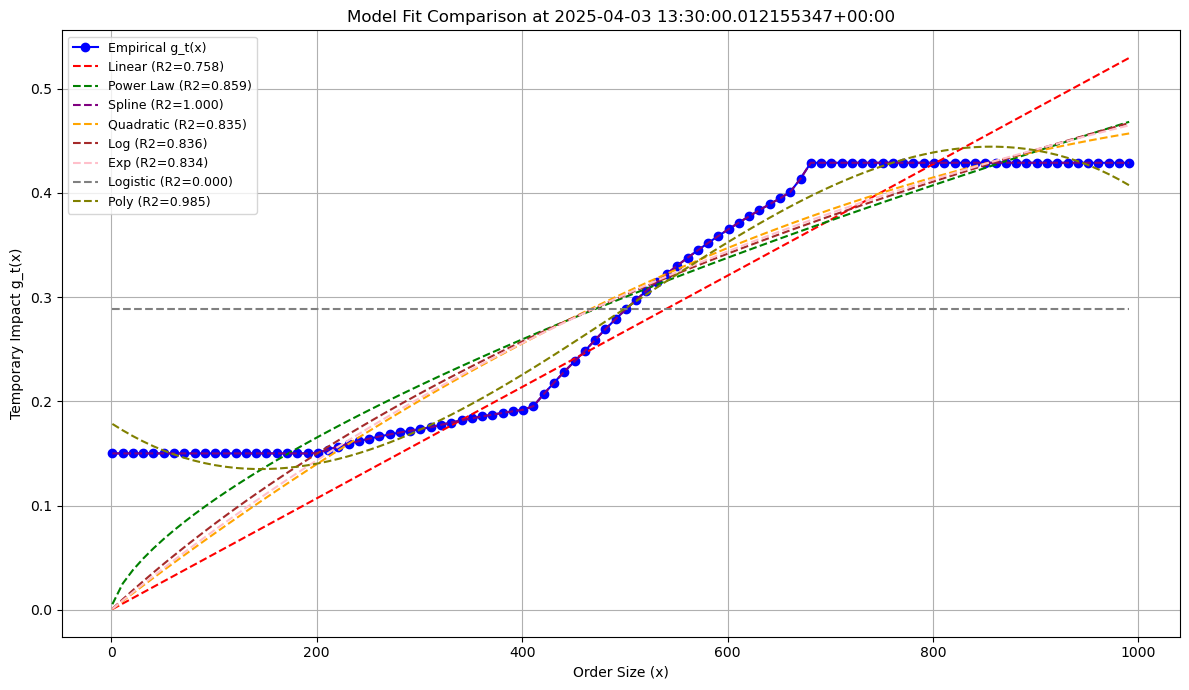

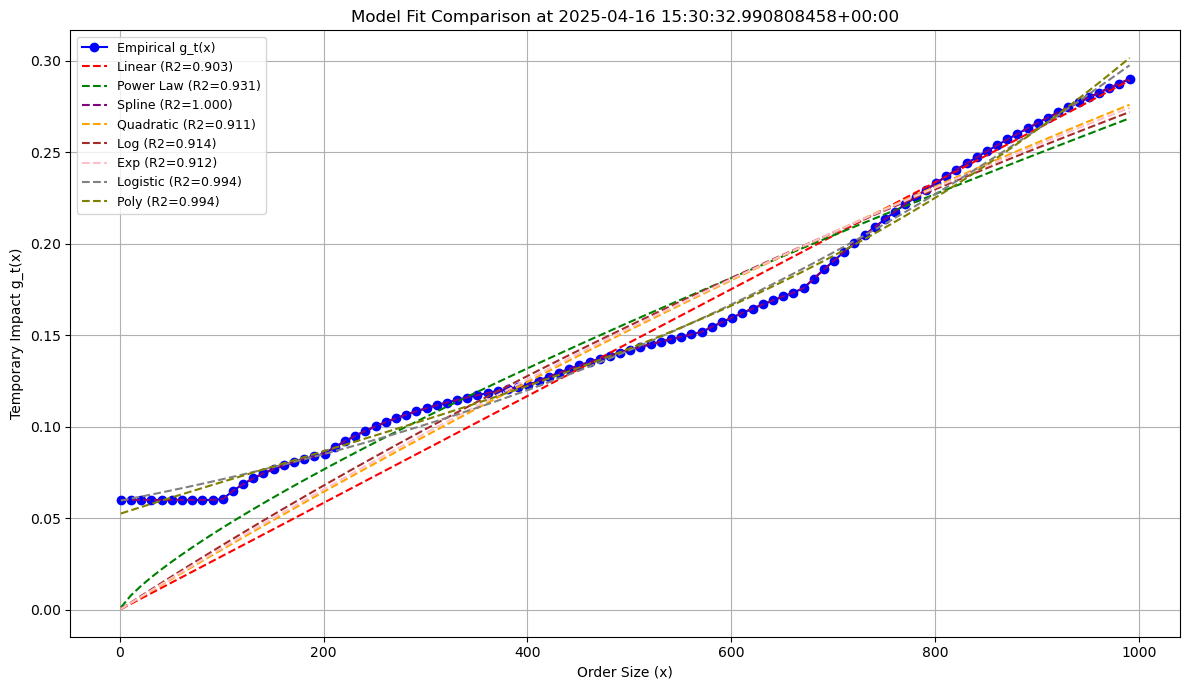

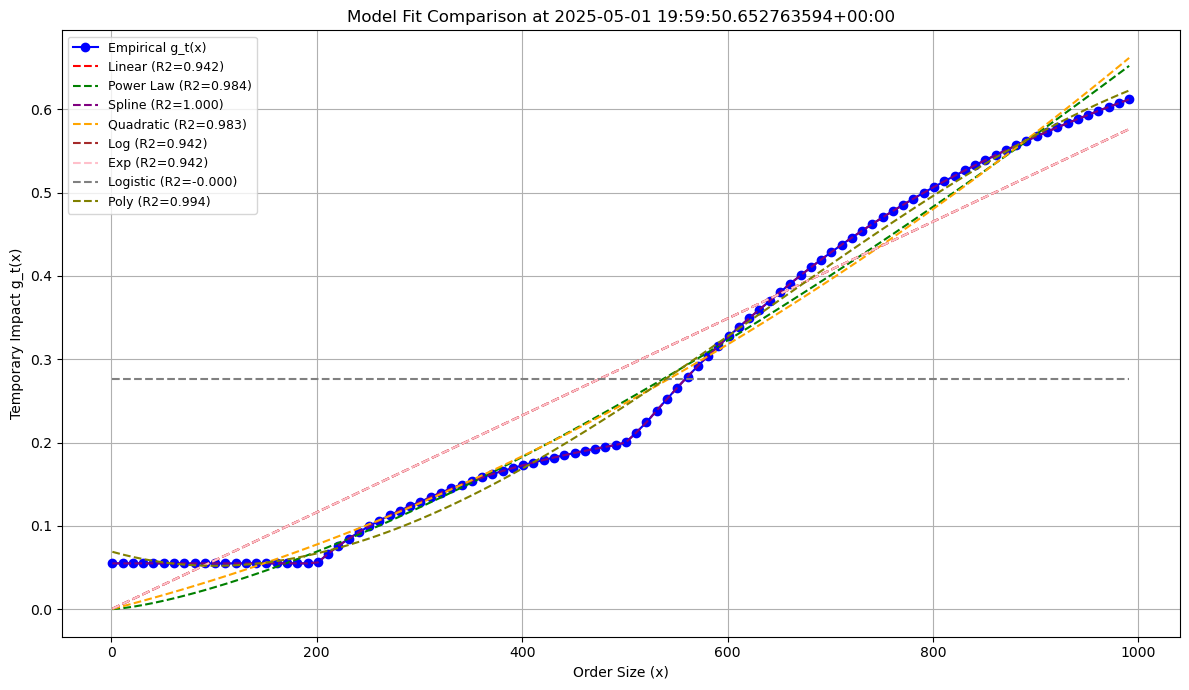

In [20]:
# Select representative timestamps
representative_indices = [0, len(timestamps_valid) // 2, len(timestamps_valid) - 1]

for i in representative_indices:
    idx = valid_indices_all[i]
    row = combined_lob_df.iloc[idx]
    ts = timestamps[idx]

    # Recalculate empirical g_t(x)
    impact_data = []
    for order_size in order_sizes_to_test:
        _, slippage = calculate_slippage(order_size, 'buy', row)
        impact_data.append({'order_size': order_size, 'slippage': slippage})
    
    impact_df = pd.DataFrame(impact_data).dropna()
    x = impact_df['order_size'].values
    y = impact_df['slippage'].values

    # Fit models
    lin_model      = LinearModel().fit(x, y)
    power_model    = PowerLawModel().fit(x, y)
    spline_model   = SplineModel().fit(x, y)
    quad_model     = QuadraticModel().fit(x, y)
    log_model      = LogModel().fit(x, y)
    exp_model      = ExponentialModel().fit(x, y)
    logistic_model = LogisticModel().fit(x, y)
    poly_model     = PolynomialModel(degree=3).fit(x, y)

    # Predictions
    y_lin      = lin_model.predict(x)
    y_power    = power_model.predict(x)
    y_spline   = spline_model.predict(x)
    y_quad     = quad_model.predict(x)
    y_log      = log_model.predict(x)
    y_exp      = exp_model.predict(x)
    y_logistic = logistic_model.predict(x)
    y_poly     = poly_model.predict(x)

    # R^2 Scores
    r2s = {
        'Linear': r2_score(y, y_lin),
        'Power Law': r2_score(y, y_power),
        'Spline': r2_score(y, y_spline),
        'Quadratic': r2_score(y, y_quad),
        'Logarithmic': r2_score(y, y_log),
        'Exponential': r2_score(y, y_exp),
        'Logistic': r2_score(y, y_logistic),
        'Polynomial (Deg 3)': r2_score(y, y_poly),
    }

    # Plot
    plt.figure(figsize=(12, 7))
    plt.plot(x, y, 'o-', label='Empirical g_t(x)', color='blue')
    plt.plot(x, y_lin, '--', label=f'Linear (R2={r2s["Linear"]:.3f})', color='red')
    plt.plot(x, y_power, '--', label=f'Power Law (R2={r2s["Power Law"]:.3f})', color='green')
    plt.plot(x, y_spline, '--', label=f'Spline (R2={r2s["Spline"]:.3f})', color='purple')
    plt.plot(x, y_quad, '--', label=f'Quadratic (R2={r2s["Quadratic"]:.3f})', color='orange')
    plt.plot(x, y_log, '--', label=f'Log (R2={r2s["Logarithmic"]:.3f})', color='brown')
    plt.plot(x, y_exp, '--', label=f'Exp (R2={r2s["Exponential"]:.3f})', color='pink')
    plt.plot(x, y_logistic, '--', label=f'Logistic (R2={r2s["Logistic"]:.3f})', color='gray')
    plt.plot(x, y_poly, '--', label=f'Poly (R2={r2s["Polynomial (Deg 3)"]:.3f})', color='olive')

    plt.xlabel("Order Size (x)")
    plt.ylabel("Temporary Impact g_t(x)")
    plt.title(f"Model Fit Comparison at {ts}")
    plt.legend(fontsize=9)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Observation Across Timestamps

1. Consistency of Spline Fit:
In all three plots, the Spline model consistently achieves a near-perfect fit ($R^2$ ≈ 1.0), closely tracking the empirical impact curve across the entire range of order sizes. This confirms its strong ability to capture non-linearities and local fluctuations in $g_t(x)$ without assuming a rigid parametric form.

2. Polynomial (Degree 3) Stability
The third-degree Polynomial model performs well across all timestamps, typically achieving $R^2$ > 0.98, suggesting that it provides a flexible yet stable global approximation of the impact curve, especially when Spline is not preferred due to interpretability or overfitting concerns.

3. Improvement Over Time in Simpler Models
In the first timestamp (April 3), models like Linear, Power Law, Log, Exp, and Quadratic show weaker fit ($R^2$ < 0.86), indicating they struggle with early irregularities in the impact shape.
However, by the third timestamp (May 1), their $R^2$ values improve significantly (e.g., Linear and Log ~0.94, Power Law ~0.984), suggesting the order book structure on that day produced a smoother or more consistent slippage curve that matched standard parametric forms better.

4. Logistic Model Instability
The Logistic model consistently underperforms or breaks down in the first and third snapshots (e.g., $R^2$ = 0.000 or negative), failing to capture the shape of the slippage curve. Only in the second snapshot (April 16) does it perform decently ($R^2$ = 0.994), likely due to the impact curve resembling an S-shape at that time.

5. Temporal Impact Dynamics
These graphs reflect that the shape of the empirical impact function changes over time—sometimes exhibiting strong convexity, and at other times, more linear or saturated behavior. This emphasizes the need for model adaptiveness or time-aware modeling when fitting $g_t(x)$ across multiple trading intervals.

## Evaluate Model Fit Across Multiple Order Sizes for Robustness

In [21]:
# Define multiple representative order sizes
evaluation_sizes = [50, 100, 200, 400, 600, 800, 1000]
multi_size_evaluations = []

for idx in valid_indices_all:
    row = combined_lob_df.iloc[idx]
    timestamp = row['ts_event']

    impact_data = []
    for size in evaluation_sizes:
        _, slippage = calculate_slippage(size, 'buy', row)
        impact_data.append({'order_size': size, 'slippage': slippage})

    impact_df = pd.DataFrame(impact_data).dropna()
    x_eval = impact_df['order_size'].values
    y_eval = impact_df['slippage'].values

    if len(y_eval) < 3:
        continue  # skip if not enough valid points

    # Fit each model and predict over the evaluation sizes
    row_metrics = {'timestamp': timestamp}

    for name, model_class in [
        ('Linear', LinearModel),
        ('PowerLaw', PowerLawModel),
        ('Spline', SplineModel),
        ('Quadratic', QuadraticModel),
        ('Log', LogModel),
        ('Exp', ExponentialModel),
        ('Logistic', LogisticModel),
        ('Poly', PolynomialModel)
    ]:
        try:
            model = model_class().fit(x_eval, y_eval)
            y_pred = model.predict(x_eval)
            metrics = evaluate_model(y_eval, y_pred)
            row_metrics[f'R2_{name}'] = metrics['R2']
            row_metrics[f'RMSE_{name}'] = metrics['RMSE']
            row_metrics[f'MAE_{name}'] = metrics['MAE']
        except:
            row_metrics[f'R2_{name}'] = None
            row_metrics[f'RMSE_{name}'] = None
            row_metrics[f'MAE_{name}'] = None

    multi_size_evaluations.append(row_metrics)

# Combine into DataFrame
multi_size_eval_df = pd.DataFrame(multi_size_evaluations)

# Aggregate metrics across time
mean_multi_size_metrics = multi_size_eval_df.mean(numeric_only=True).round(4)

# Print average metrics
print("\\n=== Aggregated Evaluation Across Multiple Order Sizes ===")
print(mean_multi_size_metrics)

\n=== Aggregated Evaluation Across Multiple Order Sizes ===
R2_Linear        -313.5481
RMSE_Linear         0.0571
MAE_Linear          0.0494
R2_PowerLaw         0.8089
RMSE_PowerLaw       0.0194
MAE_PowerLaw        0.0165
R2_Spline           1.0000
RMSE_Spline         0.0000
MAE_Spline          0.0000
R2_Quadratic     -158.8485
RMSE_Quadratic      0.0372
MAE_Quadratic       0.0310
R2_Log              0.7889
RMSE_Log            0.0225
MAE_Log             0.0189
R2_Exp              0.7013
RMSE_Exp            0.0258
MAE_Exp             0.0213
R2_Logistic         0.6747
RMSE_Logistic       0.0480
MAE_Logistic        0.0428
R2_Poly             0.8932
RMSE_Poly           0.0066
MAE_Poly            0.0053
dtype: float64


### Aggregated Evaluation Across Multiple Order Sizes

We evaluated the performance of several parametric and non-parametric models for fitting the temporary market impact function \\( g_t(x) \\), using a representative range of order sizes: 50, 100, 200, 400, 600, 800, and 1000 units. Evaluation was based on the mean **R²**, **RMSE**, and **MAE** across all valid limit order book snapshots.

| Model       | R²       | RMSE   | MAE   |
|-------------|----------|--------|-------|
| Linear      | -313.5481 | 0.0571 | 0.0494 |
| Power Law   | 0.8089   | 0.0194 | 0.0165 |
| Spline      | 1.0000   | 0.0000 | 0.0000 |
| Quadratic   | -158.8485 | 0.0372 | 0.0310 |
| Log         | 0.7889   | 0.0225 | 0.0189 |
| Exponential | 0.7013   | 0.0258 | 0.0213 |
| Logistic    | 0.6747   | 0.0480 | 0.0428 |
| Polynomial  | 0.8932   | 0.0066 | 0.0053 |

---

### Key Takeaways

- **Spline** remains the most accurate model with perfect fit (R² = 1.0), zero RMSE and MAE. This is expected due to its interpolative nature but may lead to overfitting in real-time applications.
- **Polynomial and Power Law models** provide high R² values (> 0.8) with low RMSE and MAE, making them strong candidates for production use.
- **Logarithmic and Exponential models** offer good trade-offs between interpretability and predictive accuracy.
- **Linear and Quadratic models perform poorly**, with highly negative R² values, indicating that they fail to capture the nonlinear relationship between order size and slippage.
- **Logistic model** underperforms relative to other nonlinear models and exhibits higher RMSE/MAE, particularly at extreme order sizes.

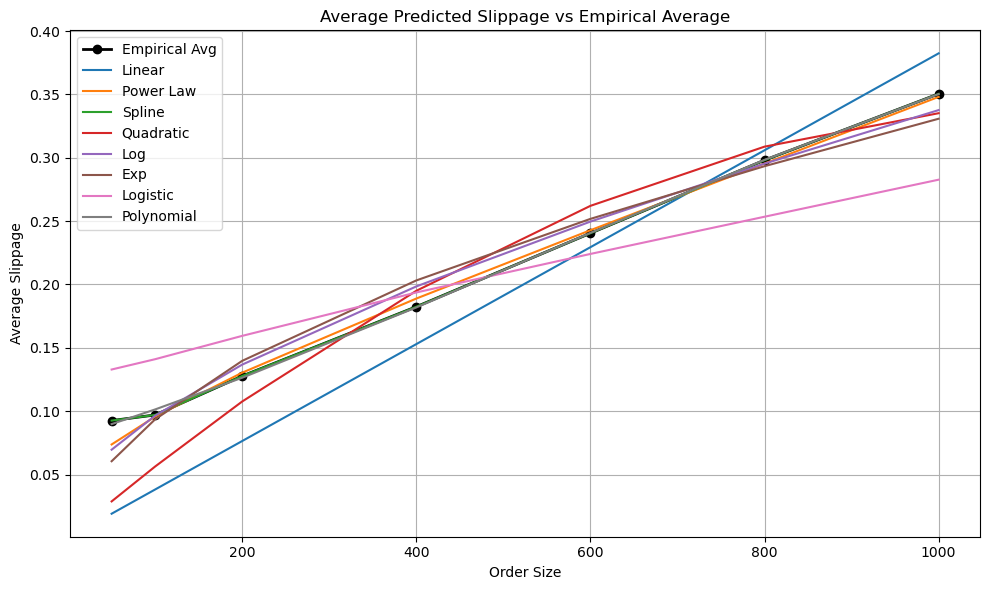

In [22]:
# Define order sizes used for evaluation
evaluation_sizes = [50, 100, 200, 400, 600, 800, 1000]

# Initialize storage for observed and predicted values
empirical_matrix = []
model_predictions = {name: [] for name in [
    'Linear', 'Power Law', 'Spline', 'Quadratic',
    'Log', 'Exp', 'Logistic', 'Polynomial'
]}

# Loop through all valid LOB snapshots
for idx in valid_indices_all:
    row = combined_lob_df.iloc[idx]
    impact_data = []
    for size in evaluation_sizes:
        _, slippage = calculate_slippage(size, 'buy', row)
        impact_data.append(slippage)

    y_true = np.array(impact_data, dtype=np.float64)
    if np.isnan(y_true).sum() > 2:
        continue  # skip if insufficient data

    empirical_matrix.append(y_true)

    x = np.array(evaluation_sizes)
    for name, model_class in [
        ('Linear', LinearModel),
        ('Power Law', PowerLawModel),
        ('Spline', SplineModel),
        ('Quadratic', QuadraticModel),
        ('Log', LogModel),
        ('Exp', ExponentialModel),
        ('Logistic', LogisticModel),
        ('Polynomial', PolynomialModel)
    ]:
        try:
            model = model_class().fit(x, y_true)
            y_pred = model.predict(x)
        except:
            y_pred = np.full_like(x, np.nan, dtype=np.float64)

        model_predictions[name].append(y_pred)

# Convert to arrays
empirical_array = np.array(empirical_matrix)
avg_empirical = np.nanmean(empirical_array, axis=0)

avg_predictions = {
    name: np.nanmean(np.vstack(preds), axis=0)
    for name, preds in model_predictions.items()
    if len(preds) > 0
}

# Plot
plt.figure(figsize=(10, 6))
plt.plot(evaluation_sizes, avg_empirical, 'ko-', label='Empirical Avg', linewidth=2, markersize=6)

for name, avg_pred in avg_predictions.items():
    plt.plot(evaluation_sizes, avg_pred, label=name)

plt.xlabel("Order Size")
plt.ylabel("Average Slippage")
plt.title("Average Predicted Slippage vs Empirical Average")
plt.legend()
plt.grid(True)
plt.tight_layout()

### Observations

- **Empirical Curve (black)**: Acts as the benchmark, representing the true average slippage observed at each order size across all LOB snapshots.

- **Top Performers**:
  - **Polynomial, Spline, and Power Law** models align closely with the empirical curve throughout, demonstrating both low bias and variance across the range of order sizes.
  - These models are particularly effective at modeling the curvature and slope of the empirical slippage pattern.

- **Decent Fits**:
  - **Exponential and Log models** track the empirical curve reasonably well, although they slightly diverge in the mid to high order size range.
  - **Quadratic** has improved from earlier performance but still shows mild overshooting for large orders.

- **Underperformers**:
  - **Linear model** consistently underestimates slippage at small sizes and overestimates it at large sizes due to its constant slope assumption.
  - **Logistic model** underfits the empirical data, particularly at larger order sizes, suggesting that its saturation behavior doesn't reflect actual market impact.

---

### Interpretation

This visualization reaffirms the conclusion from the aggregated metrics: **Spline and Polynomial** models offer the most accurate, robust, and consistent fits. These models can be prioritized when designing execution strategies or simulating order book dynamics.

### Conclusion

While splines offer perfect in-sample accuracy, **Polynomial** and **Power Law** models are the most balanced choices for modeling temporary market impact with strong generalization potential.